In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

## Cleaning and Inspecting the Data.

In [2]:
# Access the data file from the FBI: UCR 
dataset = pd.read_excel("NYCCrime.xls", header=4)

In [3]:
# Change the dataset into a DataFrame
data = pd.DataFrame(dataset)

In [4]:
# Access the Columns desired for this challenge
data_group = data.loc[:, ['City', 'Population', 'Property\ncrime', 'Robbery', 'Burglary', 'Larceny-\ntheft', 'Arson3']]

In [5]:
# Rename the group columns
data_group.columns = ['City', 'Population', 'Property crime', 'Robbery', 'Burglary', 'Theft', 'Arson']

In [6]:
# Change the Arson null values to 0. 
data_group.Arson = np.nan_to_num(data_group.Arson)

In [7]:
# Drop the remaining null values in every column. 
data_group = data_group.dropna(axis=0, how='any')

In [8]:
# Function to remove outlier data
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [9]:
# Filter the continuous variables through the outlier removal function and then drop the null values. 
for group in data_group.loc[:, 'Population':]:
    data_group[group] = reject_outliers(data_group[group], m=2)
data_group = data_group.dropna()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


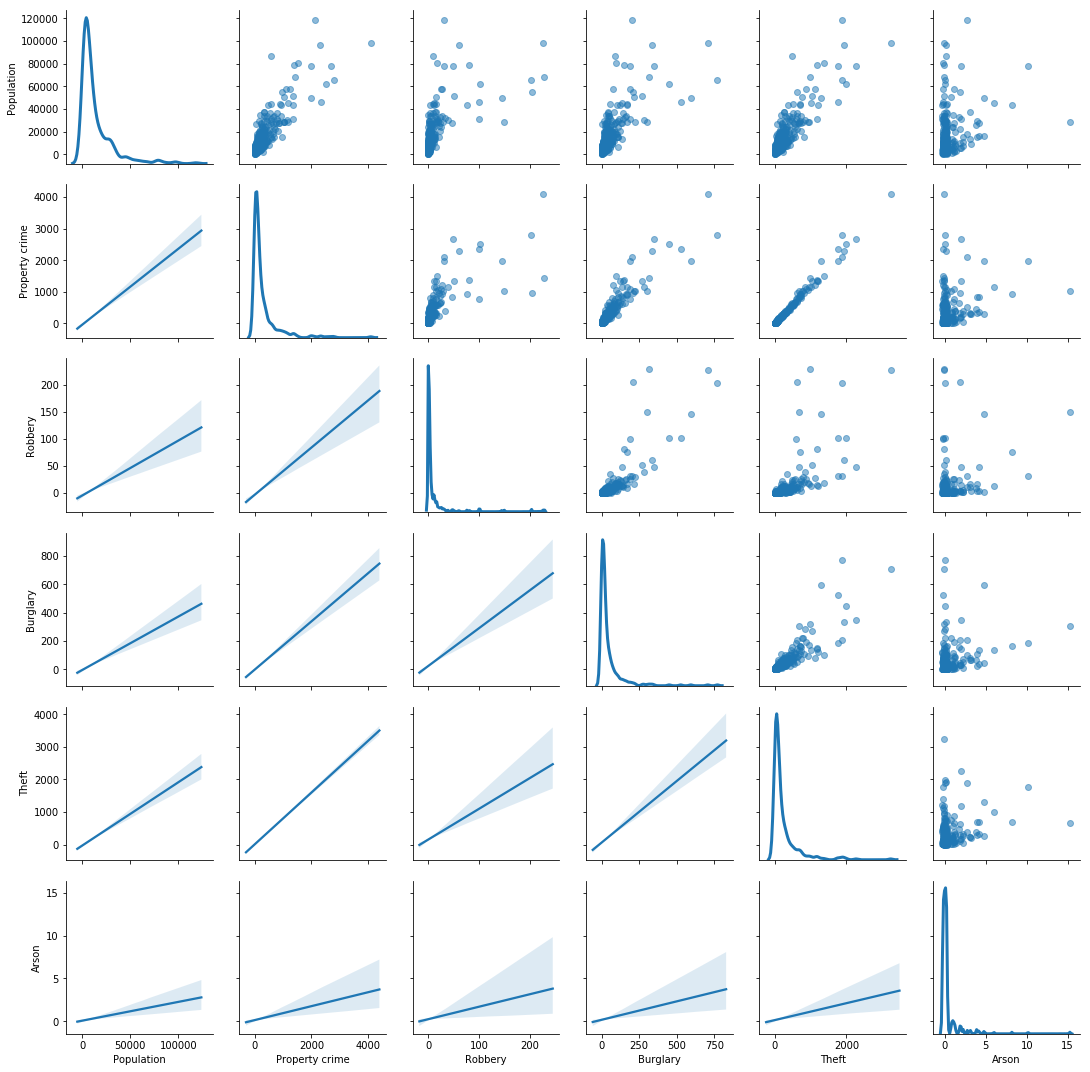

In [10]:
# Make a graph displaying the relationship of each of the continuous variables to each other. 
new_data = data_group.loc[:, 'Population':]

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(new_data.shape)),
    columns=new_data.columns
)
# Combine the data and the noise.
new_data = new_data.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(new_data.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

## My Multivariable Linear Regression Model

To demonstrate, that my model accurately predicts property crimes I'm going to show how it meets thet the four assumptions of multivariable linear regression models. 

### Assumption one: linear relationship

I chose four features that had the clearest linear relationship with the target of property crime. 

In [11]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data_group['Property crime'].values.reshape(-1, 1)
X = data_group[['Theft', 'Burglary', 'Robbery', 'Population']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

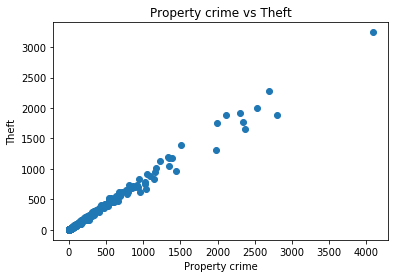

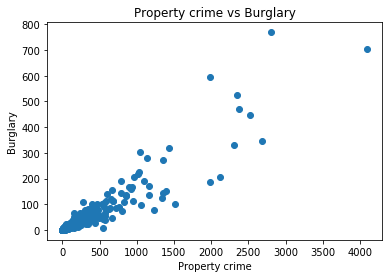

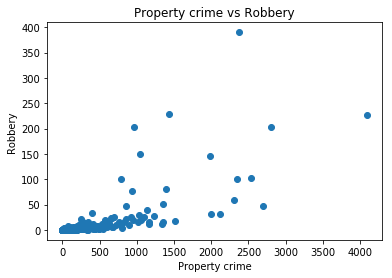

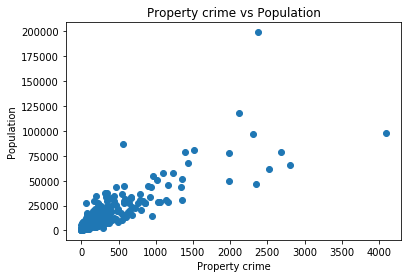

In [12]:
for each in X:
    plt.scatter(data_group['Property crime'], data_group[each])
    plt.title('Property crime vs ' + each)
    plt.xlabel('Property crime')
    plt.ylabel(each)
    plt.show()

### Assumption two: multivariate normality

The error from my model should be and is normally distributed.

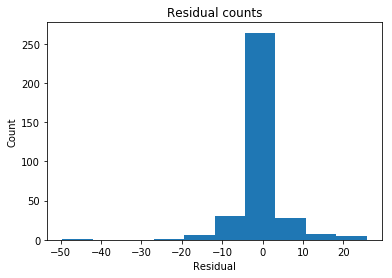

In [13]:
predicted = regr.predict(X).ravel()
actual = data_group['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Assumption three: homoscedasticity

The distribution of my error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic. Overall, my error terms range between -20 and 20 for values between 500 and 4000 with one outlier. 

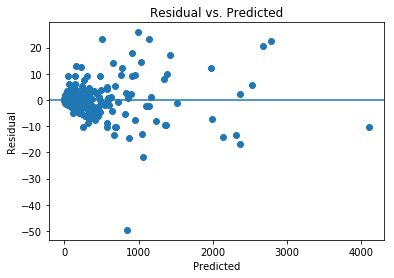

In [14]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Assumption four: low multicollinearity

This appears to be the weakest part of my model because my feature correlation is moderate to high. However, since my only goal is prediction, all that matters is that the variance gets explained.

In [15]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Theft,Burglary,Robbery,Population
Theft,1.000,0.879,0.661,0.834
Burglary,0.879,1.000,0.808,0.735
Robbery,0.661,0.808,1.000,0.727
Population,0.834,0.735,0.727,1.000


## Checking for Overfitting

I'm going to see if my results change by checking my model with training and test groups. 

In [16]:
# Test my model with different holdout groups.
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Classify, storing the result in a training variable and Fit our model to the data.
train_pred = regr.fit(data_train, target_train,).predict(data_train)

# Display our Training results.
print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print(regr.score(X, Y))


# Classify, storing the result in a testing variable and Fit our model to the data.
test_pred = regr.fit(data_test, target_test).predict(data_test)

# Display our Testing results
print('\nTesting Coefficients: \n', regr.coef_)
print('\nTesting Intercept: \n', regr.intercept_)
print('\nTesting R-squared:')
print(regr.score(X, Y))


Training Coefficients: 
 [[  1.00841083e+00   1.01342677e+00   4.85585897e-01   1.33795743e-04]]

Training Intercept: 
 [-0.47606445]

Training R-squared:
0.99985730561

Testing Coefficients: 
 [[  1.00325994e+00   1.00569049e+00   4.90179782e-01   1.50318641e-04]]

Testing Intercept: 
 [ 0.29966254]

Testing R-squared:
0.999849484298


As you can see, even when splitting up my dataset into training and testing groups, the accuracy remains consistent for both groups. 